## Summer Events in Seattle vs. Seattle AirBnB Market

1. Which major Seattle events seemed to have had an impact on Seattle AirBNB Market?
2. What locations appear to be most effected by event attendance?
3. How did transit connectivity impact AirBNB market during SIFF?
4. How did number of available rooms/travelers effect AirBNB market during SIFF?
5. What is the best time and location for a couple to reserve an AirBNB during SIFF?

In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scripts.utility import *

%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# load data
listings_df = pd.read_csv("data/listings.csv")
calendar_df = pd.read_csv("data/calendar.csv")
reviews_df = pd.read_csv("data/reviews.csv")

<IPython.core.display.Javascript object>

### Basic summary of data

In [3]:
print(calendar_df["listing_id"].count())
print(listings_df["id"].count())
print(reviews_df["id"].count())

1393570
3818
84849


<IPython.core.display.Javascript object>

In [4]:
# check percentage of null values
(len(calendar_df) - calendar_df.count()).div(len(calendar_df) * 100)

listing_id    0.000000
date          0.000000
available     0.000000
price         0.003294
dtype: float64

<IPython.core.display.Javascript object>

There are 3,818 unique listings in the dataset to which 1,395,570 stays are attributed througout 2016. Prices are only given for days in which the airbnb was available. 

Availability is expressed as a state where the airbnb is blocked out, not necessarily booked. So this metric cannot be taken as occupancy metric. For this, historical review frequency was used as a rough analog for occupancy.

### Preprocessing

In [5]:
calendar_df.count()

listing_id    1393570
date          1393570
available     1393570
price          934542
dtype: int64

<IPython.core.display.Javascript object>

In [6]:
# drop duplicate records
# calendar_df.drop_duplicates()
# reviews_df.drop_duplicates()
# listings_df.drop_duplicates()

<IPython.core.display.Javascript object>

In [7]:
# convert price to clean floating field
calendar_df["price"] = format_dollar_field(calendar_df["price"])

# create various timeframe groupings for calendar
calendar_df["date"] = pd.to_datetime(calendar_df["date"])
calendar_df["week"] = calendar_df["date"].map(lambda date: date.isocalendar()[1])
calendar_df["month"] = calendar_df["date"].map(lambda date: date.month)

<IPython.core.display.Javascript object>

In [8]:
# create various timeframe groupings for reviews
reviews_df["date"] = pd.to_datetime(reviews_df["date"])
reviews_df["week"] = reviews_df["date"].map(lambda date: date.isocalendar()[1])
reviews_df["month"] = reviews_df["date"].map(lambda date: date.month)
reviews_df["year"] = reviews_df["date"].map(lambda date: str(date.year))

<IPython.core.display.Javascript object>

In [138]:
# get a location-based variable with with transit and review count
listings_trimmed_df = listings_df[
    [
        "id",
        "neighbourhood_group_cleansed",
        "latitude",
        "longitude",
        "transit",
        "zipcode",
        "reviews_per_month",
    ]
]
location_df = calendar_df.join(listings_trimmed_df, lsuffix="listing_id", rsuffix="id")

# rename to correct spelling :)
location_df = location_df.rename(
    columns={"neighbourhood_group_cleansed": "neighborhood"}
)
location_df["id"] = location_df["id"].astype(str).str.replace(".0", "")

<IPython.core.display.Javascript object>

### Create date masks

In [81]:
bumbershoot_dates = (
    pd.to_datetime("2016-09-4", format="%Y-%m-%d"),
    pd.to_datetime("2016-09-6", format="%Y-%m-%d"),
)
siff_dates = (
    pd.to_datetime("2016-05-19", format="%Y-%m-%d"),
    pd.to_datetime("2016-06-12", format="%Y-%m-%d"),
)
hempfest_dates = (
    pd.to_datetime("2016-08-14", format="%Y-%m-%d"),
    pd.to_datetime("2016-08-18", format="%Y-%m-%d"),
)
pride_dates = (
    pd.to_datetime("2016-06-20", format="%Y-%m-%d"),
    pd.to_datetime("2016-06-28", format="%Y-%m-%d"),
)
summer_dates = (
    pd.to_datetime("2016-05-20", format="%Y-%m-%d"),
    pd.to_datetime("2016-09-15", format="%Y-%m-%d"),
)

bumbershoot_dates = {
    "day_start": bumbershoot_dates[0],
    "day_end": bumbershoot_dates[1],
    "week_start": bumbershoot_dates[0].week,
    "week_end": bumbershoot_dates[1].week,
    "month_start": bumbershoot_dates[0].month,
    "month_end": bumbershoot_dates[1].month,
}
siff_dates = {
    "day_start": siff_dates[0],
    "day_end": siff_dates[1],
    "week_start": siff_dates[0].week,
    "week_end": siff_dates[1].week,
    "month_start": siff_dates[0].month,
    "month_end": siff_dates[1].month,
}
hempfest_dates = {
    "day_start": hempfest_dates[0],
    "day_end": hempfest_dates[1],
    "week_start": hempfest_dates[0].week,
    "week_end": hempfest_dates[1].week,
    "month_start": hempfest_dates[0].month,
    "month_end": hempfest_dates[1].month,
}
pride_dates = {
    "day_start": pride_dates[0],
    "day_end": pride_dates[1],
    "week_start": pride_dates[0].week,
    "week_end": pride_dates[1].week,
    "month_start": pride_dates[0].month,
    "month_end": pride_dates[1].month,
}
summer_dates = {
    "day_start": summer_dates[0],
    "day_end": summer_dates[1],
    "week_start": summer_dates[0].week,
    "week_end": summer_dates[1].week,
    "month_start": summer_dates[0].month,
    "month_end": summer_dates[1].month,
}

all_events = {
    "bumbershoot": bumbershoot_dates,
    "siff": siff_dates,
    "hempfest": hempfest_dates,
    "pride": pride_dates,
}

<IPython.core.display.Javascript object>

### Calculate additional metrics

In [11]:
# calculate availability metrics by day/week/month
listings_byday_df = (
    calendar_df[calendar_df["available"] == "t"][["listing_id", "date"]]
    .groupby("date")
    .count()
)
listings_byweek_df = (
    calendar_df[calendar_df["available"] == "t"][["listing_id", "week"]]
    .groupby("week")
    .count()
)
listings_bymonth_df = (
    calendar_df[calendar_df["available"] == "t"][["listing_id", "month"]]
    .groupby("month")
    .count()
)

total_byday_df = calendar_df[["available", "date"]].groupby("date").count()
total_byweek_df = calendar_df[["available", "week"]].groupby("week").count()
total_bymonth_df = calendar_df[["available", "month"]].groupby("month").count()

availability_rate = dict()
availability_rate["day"] = listings_byday_df["listing_id"] / total_byday_df["available"]
availability_rate["week"] = (
    listings_byweek_df["listing_id"] / total_byweek_df["available"]
)
availability_rate["month"] = (
    listings_bymonth_df["listing_id"] / total_bymonth_df["available"]
)

availability_perc_change = dict()
availability_perc_change["week"] = availability_rate["week"].pct_change(periods=1)
availability_perc_change["month"] = availability_rate["month"].pct_change(periods=1)

<IPython.core.display.Javascript object>

In [12]:
# calculate the price metrics listing prices (by day/week/month)
price_time_mean = dict()
avail_df = calendar_df[calendar_df["available"] == "t"]
price_time_mean["day"] = avail_df[["price", "date"]].groupby("date").mean()
price_time_mean["week"] = avail_df[["price", "week"]].groupby("week").mean()
price_time_mean["month"] = avail_df[["price", "month"]].groupby("month").mean()

price_time_std = dict()
price_time_std["day"] = avail_df[["price", "date"]].groupby("date").std()
price_time_std["week"] = avail_df[["price", "week"]].groupby("week").std()
price_time_std["month"] = avail_df[["price", "month"]].groupby("month").std()

price_perc_change = dict()
price_perc_change["week"] = price_time_mean["week"].pct_change(periods=1)
price_perc_change["month"] = price_time_mean["month"].pct_change(periods=1)

<IPython.core.display.Javascript object>

In [13]:
# calculate review counts
review_counts = dict()
review_counts["week"] = reviews_df[["week", "listing_id"]].groupby("week").count()
review_counts["month"] = reviews_df[["month", "listing_id"]].groupby("month").count()
# get average review by week and month

<IPython.core.display.Javascript object>

## Which major Seattle events seemed to have had an impact on Seattle's AirBNB Market?

/Users/dmoton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


<Figure size 432x288 with 0 Axes>

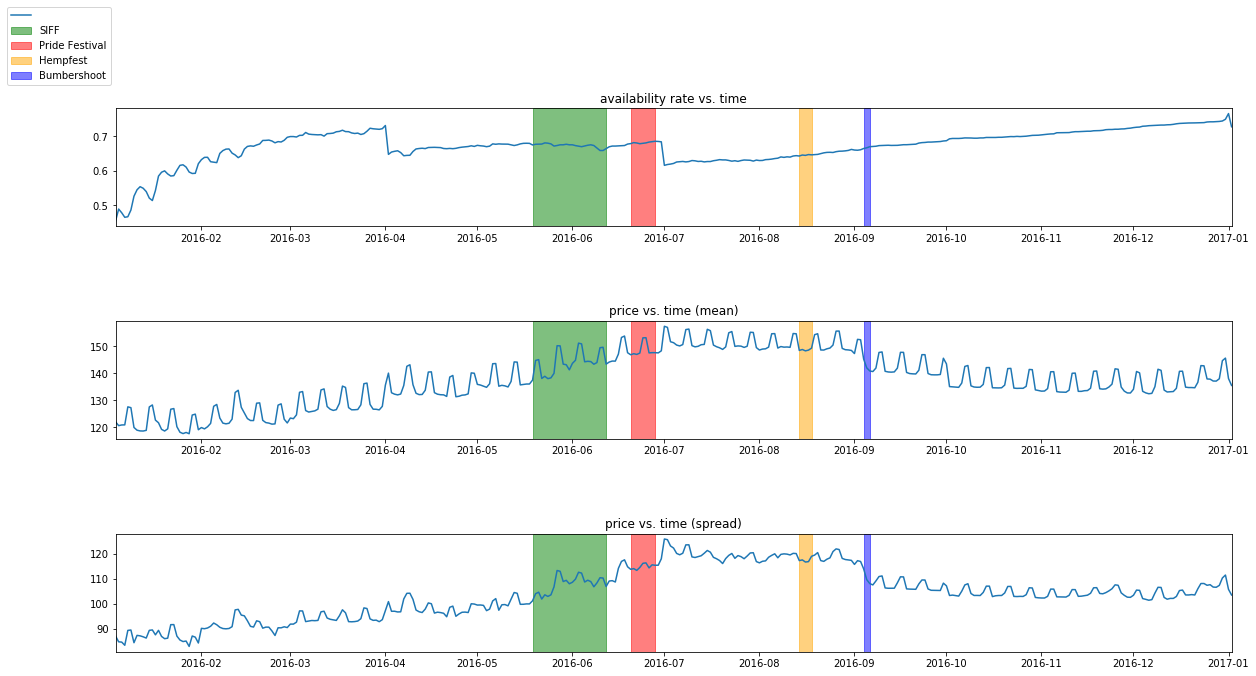

<IPython.core.display.Javascript object>

In [14]:
plt.clf()

fig, initial_plt = plt.subplots(3)

initial_plt[0].plot(availability_rate["day"])
initial_plt[0].set_title("availability rate vs. time")
initial_plt[1].plot(price_time_mean["day"])
initial_plt[1].set_title("price vs. time (mean)")
initial_plt[2].plot(price_time_std["day"])
initial_plt[2].set_title("price vs. time (spread)")

for plot in initial_plt:
    plot.axvspan(
        siff_dates["day_start"], siff_dates["day_end"], color="green", alpha=0.5
    )
    plot.axvspan(
        pride_dates["day_start"], pride_dates["day_end"], color="red", alpha=0.5
    )
    plot.axvspan(
        hempfest_dates["day_start"],
        hempfest_dates["day_end"],
        color="orange",
        alpha=0.5,
    )
    plot.axvspan(
        bumbershoot_dates["day_start"],
        bumbershoot_dates["day_end"],
        color="blue",
        alpha=0.5,
    )
    plot.margins(x=0)

# Add legend at top left
plt.gcf().set_size_inches(20, 10)
plt.subplots_adjust(hspace=0.8)
plt.legend(
    initial_plt,
    labels=["", "SIFF", "Pride Festival", "Hempfest", "Bumbershoot"],
    loc="upper right",
    bbox_to_anchor=(0, 5.5),
)
plt.show()

/Users/dmoton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


<Figure size 432x288 with 0 Axes>

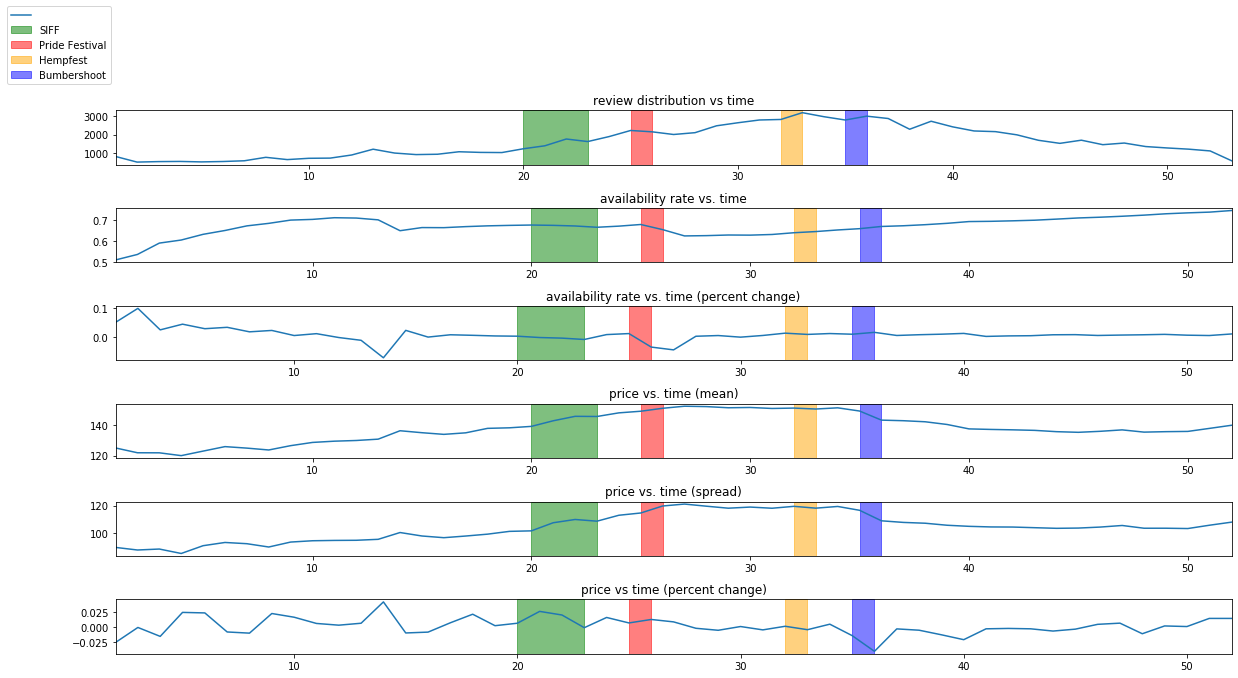

<IPython.core.display.Javascript object>

In [15]:
plt.clf()

fig, initial_plt = plt.subplots(6)

measures_tuple = (
    (review_counts["week"], "review distribution vs time"),
    (availability_rate["week"], "availability rate vs. time"),
    (availability_perc_change["week"], "availability rate vs. time (percent change)"),
    (price_time_mean["week"], "price vs. time (mean)"),
    (price_time_std["week"], "price vs. time (spread)"),
    (price_perc_change["week"], "price vs time (percent change)"),
)

# create initial plots from relevant measures
for index, plot in enumerate(initial_plt):
    initial_plt[index].plot(measures_tuple[index][0])
    initial_plt[index].set_title(measures_tuple[index][1])

for plot in initial_plt:
    plot.axvspan(
        siff_dates["week_start"], siff_dates["week_end"], color="green", alpha=0.5
    )
    plot.axvspan(
        pride_dates["week_start"], pride_dates["week_end"], color="red", alpha=0.5
    )
    plot.axvspan(
        hempfest_dates["week_start"],
        hempfest_dates["week_end"],
        color="orange",
        alpha=0.5,
    )
    plot.axvspan(
        bumbershoot_dates["week_start"],
        bumbershoot_dates["week_end"],
        color="blue",
        alpha=0.5,
    )
    plot.margins(x=0)

# Add legend at top left
plt.gcf().set_size_inches(20, 10)
plt.subplots_adjust(hspace=0.8)
plt.legend(
    initial_plt,
    labels=["", "SIFF", "Pride Festival", "Hempfest", "Bumbershoot"],
    loc="upper right",
    bbox_to_anchor=(0, 12),
)
plt.show()

### Seattle International Film Festival (19 May - 12 June)
The SIFF is an international film festival taking place around Downtown Seattle. There is no meaningful increase in availability and only a modest increase in price. The historical review total steadily increases during the festival, which might suggest increased demand, but it's not really that distinct compared to the general increase in the Summer months.

Just over 70 pecent of attendees to SIFF come from the Seattle area, so that might explain why we don't really see a noticeable jump in attendance or review distribution that you might expect to see from travellers coming from out-of-town. 

- https://www.siff.net/Documents/DEVO/Sponsorship/DEV_sponsorshipdeck_2019.pdf

### Seattle Pride Festival (20 - 28 June)
The Seattle Pride festival is an annual celebration held towards the end of June by the local LGBT community. Seattle's Pride parade is the fourth largest such parade in the nation and Seattle was rated one of the best cities in the US for LGBT individuals in a NerdWallet study. Given this context, we might expect there to be a fair amount of travelers adding to the AirBnB demand during the weeklong event.

There is a steady increase in price for the listings during the Pride Festival, and the average price seems to plateau after the festival. We do see a sudden decline in availability during the week of the festival, but it's not accompanied by a historical increase in reviews in the following week.

- https://www.nerdwallet.com/blog/mortgages/top-lgbt-friendly-cities-2015/
- https://www.seattlepride.org/2019/04/29/2019-seattle-pride-to-honor-50th-anniversary-of-stonewall/

### Hempfest (14 - 18 August)

Hempfest began in Seattle in 1991 as the "Washington Hemp Expo" with Cannabis policy reform being the major thrust behind it. Since then, it has become the world's largest gathering advocating for the decrimininalization of marijuana; it typically brings in over 100,000 attendees during the three-day event.

The number of reviews is the only noticeable change I see in the data during Hempfest. However, it's difficult to determine how many of the reviews are actually related to Hempfest - a quick glance at some reviews don't offer much help:

In [16]:
hf_reviews_df = reviews_df[
    (pd.to_datetime(reviews_df["date"]).dt.week >= hempfest_dates["week_start"])
    & (pd.to_datetime(reviews_df["date"]).dt.week <= hempfest_dates["week_end"] + 2)
]

<IPython.core.display.Javascript object>

In [17]:
# collect some potentially hempfest-related reviews
search_for = ["festival", "Festival", "FESTIVAL", "hempfest", "HEMPFEST", "Hempfest"]
hempfest_reviews = hf_reviews_df[
    hf_reviews_df["comments"].str.contains("|".join(search_for)) == True
]["comments"]

hempfest_reviews

12279    Great place.  Slept 6 comfortably, very clean ...
13259    The Garden Cottage is comfortable for people w...
20824    What a lovely stay.  Short of providing great ...
37201    Though I didn't see Tiffany much because I was...
38493    Renee was a great host. She was very nice and ...
45503    This was the first Airbnb experience for me an...
62149    This was my first Airbnb experience, and I mus...
75699    This charming apartment is part of a charming ...
Name: comments, dtype: object

<IPython.core.display.Javascript object>

In [18]:
hempfest_reviews.count() / hf_reviews_df["comments"].count()

0.0006818956699624957

<IPython.core.display.Javascript object>

A possible reason for the lack of visible impact on the AirBnB market may relate to the fact that Hempfest has it's own campgrounds where attendees can stay as well as partnerships with local hotels.

- https://www.hempfest.org/about/history/

### Bumbershoot (4 - 6 September)
Bumbershoot is one of the largest music and arts festival in North America. It takes place at Seattle's Seattle Center between 4-6 September. When it was first launched as the "Mayor's Festival" in 1971, it attracted around 120,000 people. More recently, attendance has settled between 70,000 and 80,000.

The availability rate for AirBnB's don't show much change during this event. There is a sharp decrease in average price for a stay during the event, but this may be because Bumbershoot is the last major Summer event in Seattle, and AirBnB hosts are lowering their listing prices in anticipation of lower demand.

- https://en.wikipedia.org/wiki/Bumbershoot 
- https://www.historylink.org/File/20852

### Summary

Based on the data available, the **Seattle Pride Festival** seemed to be the event that had the biggest impact on Seattle's AirBnB market in 2016. The caveat is that the given dataset isn't rich enough for me to confidently separate signal from noise - determining how much of the changes are really caused by the events. A true occupancy metric would have been much better in making that determination. 

We've looked primarily at general attendance and review data to make insights into how various Summer events impacted Seattle AirBnB market. Let's take a look at another dimension - location - in understading how these events might have had an impact.

## What locations appear to be most effected by event attendance?

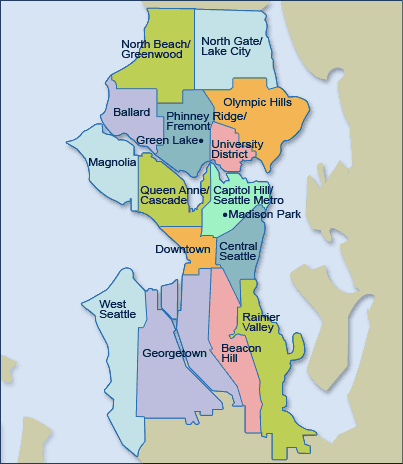

In [19]:
location_stats_df = (
    location_df[["neighborhood", "price", "reviews_per_month"]]
    .groupby("neighborhood")
    .agg(
        {
            "neighborhood": ["count"],
            "price": ["mean", "std"],
            "reviews_per_month": ["mean"],
        }
    )
    .sort_values(("neighborhood", "count"), ascending=False)
)
location_stats_df

neighborhood       price             reviews_per_month
                           count        mean         std              mean
neighborhood                                                              
Other neighborhoods          794   88.007557   65.514031          1.817139
Capitol Hill                 567   54.573192   66.579832          2.010974
Downtown                     530  332.735849  371.648942          2.345764
Central Area                 369  668.186992  637.877604          2.197188
Queen Anne                   295   91.745763   39.005230          2.147460
Ballard                      230   82.217391   21.688458          2.570725
West Seattle                 203  293.724138  195.864327          1.860366
Rainier Valley               159   77.735849   34.346052          2.478881
University District          122  124.188525  214.318190          1.641429
Beacon Hill                  118  125.762712    9.096518          2.432233
Cascade                       89   96.539326  285.537494          1.805077
Northgate                     80   59.462500   45.500854          1.612121
Delridge                      79  127.113924   53.609937          2.182308
Lake City                     67   90.000000    0.000000          1.544821
Magnolia                      61   54.540984   88.802698          1.540851
Seward Park                   44   80.000000    0.000000          2.580513
Interbay                      11  114.545455   39.080337          2.022222

<IPython.core.display.Javascript object>

In [22]:
# remove vague "Other" option and choose only the top 10 neighborhoods
all_neighborhoods = location_stats_df[("neighborhood", "count")].index.to_list()
all_neighborhoods.remove("Other neighborhoods")
top_neighborhoods = all_neighborhoods[0:10]
print(top_neighborhoods)

top_neighborhoods_df = location_df[location_df["neighborhood"].isin(top_neighborhoods)]

['Capitol Hill', 'Downtown', 'Central Area', 'Queen Anne', 'Ballard', 'West Seattle', 'Rainier Valley', 'University District', 'Beacon Hill', 'Cascade']


<IPython.core.display.Javascript object>

In [23]:
# calculate the price metrics listing prices (by day/week/month)
loc_pricetime_mean = dict()
loc_avail_df = top_neighborhoods_df[top_neighborhoods_df["available"] == "t"][
    ["neighborhood", "price", "week", "date", "month"]
]
loc_avail_df

,neighborhood,price,week,date,month
0,Queen Anne,85.0,1,2016-01-04,1
1,Queen Anne,85.0,1,2016-01-05,1
9,Queen Anne,85.0,2,2016-01-13,1
10,Queen Anne,85.0,2,2016-01-14,1
14,Queen Anne,85.0,3,2016-01-18,1
...,...,...,...,...,...
3634,Capitol Hill,232.0,50,2016-12-18,12
3635,Capitol Hill,217.0,51,2016-12-19,12
3636,Capitol Hill,203.0,51,2016-12-20,12
3637,Capitol Hill,188.0,51,2016-12-21,12


<IPython.core.display.Javascript object>

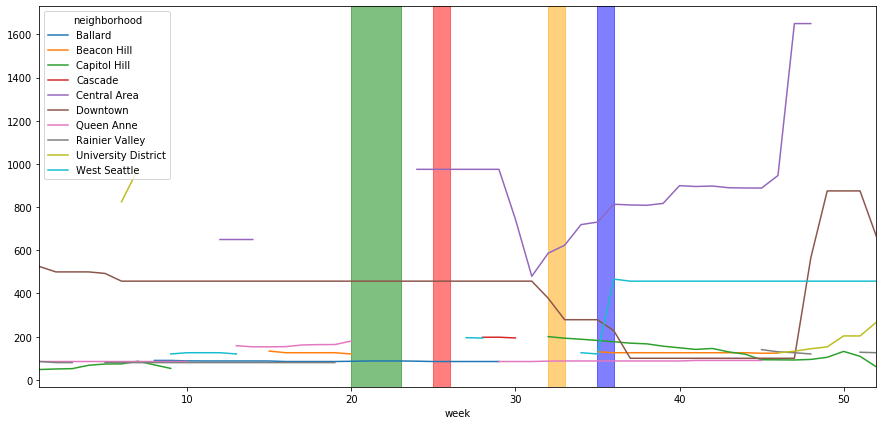

<IPython.core.display.Javascript object>

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))
top_neighborhoods_df[top_neighborhoods_df["available"] == "t"].groupby(
    ["week", "neighborhood"]
).mean()["price"].unstack().plot(ax=ax)

ax.axvspan(siff_dates["week_start"], siff_dates["week_end"], color="green", alpha=0.5)
ax.axvspan(pride_dates["week_start"], pride_dates["week_end"], color="red", alpha=0.5)
ax.axvspan(
    hempfest_dates["week_start"], hempfest_dates["week_end"], color="orange", alpha=0.5,
)
ax.axvspan(
    bumbershoot_dates["week_start"],
    bumbershoot_dates["week_end"],
    color="blue",
    alpha=0.5,
)
ax.margins(x=0)

In [101]:
price_buckets = list(range(0, 1200, 200))
all_events.update({"summer": summer_dates})
avail_df = top_neighborhoods_df[top_neighborhoods_df["available"] == "t"]
for event_name, event in all_events.items():
    event_slice_df = time_slice(
        avail_df.set_index("date"),
        event["day_start"] - timedelta(days=7),
        event["day_end"] + timedelta(days=3),
    )
    price_std = event_slice_df.groupby("neighborhood").agg(
        {"price": ["mean", "std"], "listing_id": ["count"]}
    )
    price_group = event_slice_df.groupby(
        pd.cut(event_slice_df.price, price_buckets)
    ).listing_id.count()

    print(event_name, "__________________")
    print("\n", price_std)
    print("\n", price_group)
    print("\n\n")

bumbershoot __________________

                    price             listing_id
                    mean         std      count
neighborhood                                   
Beacon Hill   126.666667   10.000000          9
Capitol Hill  179.923077    7.825828         13
Central Area  761.115385  597.071609         26
Downtown      270.000000  180.710404         25
Queen Anne     87.500000    2.549510         26
West Seattle  191.000000  158.760826          5

 price
(0, 200]       78
(200, 400]      0
(400, 600]     13
(600, 800]      0
(800, 1000]     0
Name: listing_id, dtype: int64



siff __________________

                      price            listing_id
                      mean        std      count
neighborhood                                    
Ballard          87.131148   2.493160         61
Beacon Hill     125.714286   9.759001          7
Downtown        457.142857  11.458731         35
Queen Anne      174.142857   7.625146          7
Rainier Valley   80.000000   0.000

<IPython.core.display.Javascript object>

In [59]:
loc_total_df = top_neighborhoods_df[["available", "date", 'neighborhood']].groupby(["date", 'neighborhood']).count()
loc_avail_byday_df = (
    top_neighborhoods_df[top_neighborhoods_df["available"] == "t"][
        ["listing_id", "date"]
    ]
    .groupby("date")
    .count()
)

<IPython.core.display.Javascript object>